# Zillow: Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats

from acquire import get_zillow_data
from wrangle_zillow import handle_missing_values, impute_missing_data

from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
df = get_zillow_data()
df = handle_missing_values(df)
train_validate, test = train_test_split(df, train_size=.8)
train, validate = train_test_split(train_validate, test_size=.2)

train, validate, test = impute_missing_data(train, validate, test)

In [3]:
print(df.shape)
print(train.shape)
# train.isna().sum()

(76721, 24)
(49100, 24)


In [4]:
df.isna().sum()[df.isna().sum()>0]

calculatedfinishedsquarefeet      11
lotsizesquarefeet               8151
regionidcity                    1447
regionidzip                       44
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              223
dtype: int64

In [5]:
df['roomcnt'] = np.where(df.roomcnt == 0, df.bathroomcnt + df.bedroomcnt, df.roomcnt)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49100 entries, 14351 to 70087
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      49100 non-null  int64  
 1   bathroomcnt                   49100 non-null  float64
 2   bedroomcnt                    49100 non-null  float64
 3   calculatedfinishedsquarefeet  49100 non-null  float64
 4   fips                          49100 non-null  float64
 5   latitude                      49100 non-null  float64
 6   longitude                     49100 non-null  float64
 7   lotsizesquarefeet             49100 non-null  float64
 8   propertycountylandusecode     49100 non-null  object 
 9   rawcensustractandblock        49100 non-null  float64
 10  regionidcity                  49100 non-null  float64
 11  regionidcounty                49100 non-null  float64
 12  regionidzip                   49100 non-null  float64
 1

In [7]:
train.nunique().sort_values()

assessmentyear                      1
regionidcounty                      3
fips                                3
propertylandusedesc                12
bedroomcnt                         14
bathroomcnt                        21
roomcnt                            34
propertycountylandusecode          67
yearbuilt                         133
regionidcity                      175
lasttransactiondate               258
regionidzip                       387
calculatedfinishedsquarefeet     4484
lotsizesquarefeet               15207
censustractandblock             29122
rawcensustractandblock          29287
structuretaxvaluedollarcnt      34853
taxvaluedollarcnt               34875
landtaxvaluedollarcnt           35247
longitude                       40602
latitude                        42196
taxamount                       47586
logerror                        48855
parcelid                        49032
dtype: int64

In [8]:
numeric_columns = train.nunique()[(train.nunique()>387)].index.to_list()

1. Plot all continuous or numeric/ordered variables against each other in scatterplots, or through a pairplot.

In [9]:
numeric_columns.remove('latitude')
numeric_columns.remove('longitude')
numeric_columns.remove('rawcensustractandblock')
numeric_columns.remove('censustractandblock')
numeric_columns.remove('parcelid')

In [10]:
len(numeric_columns)

7

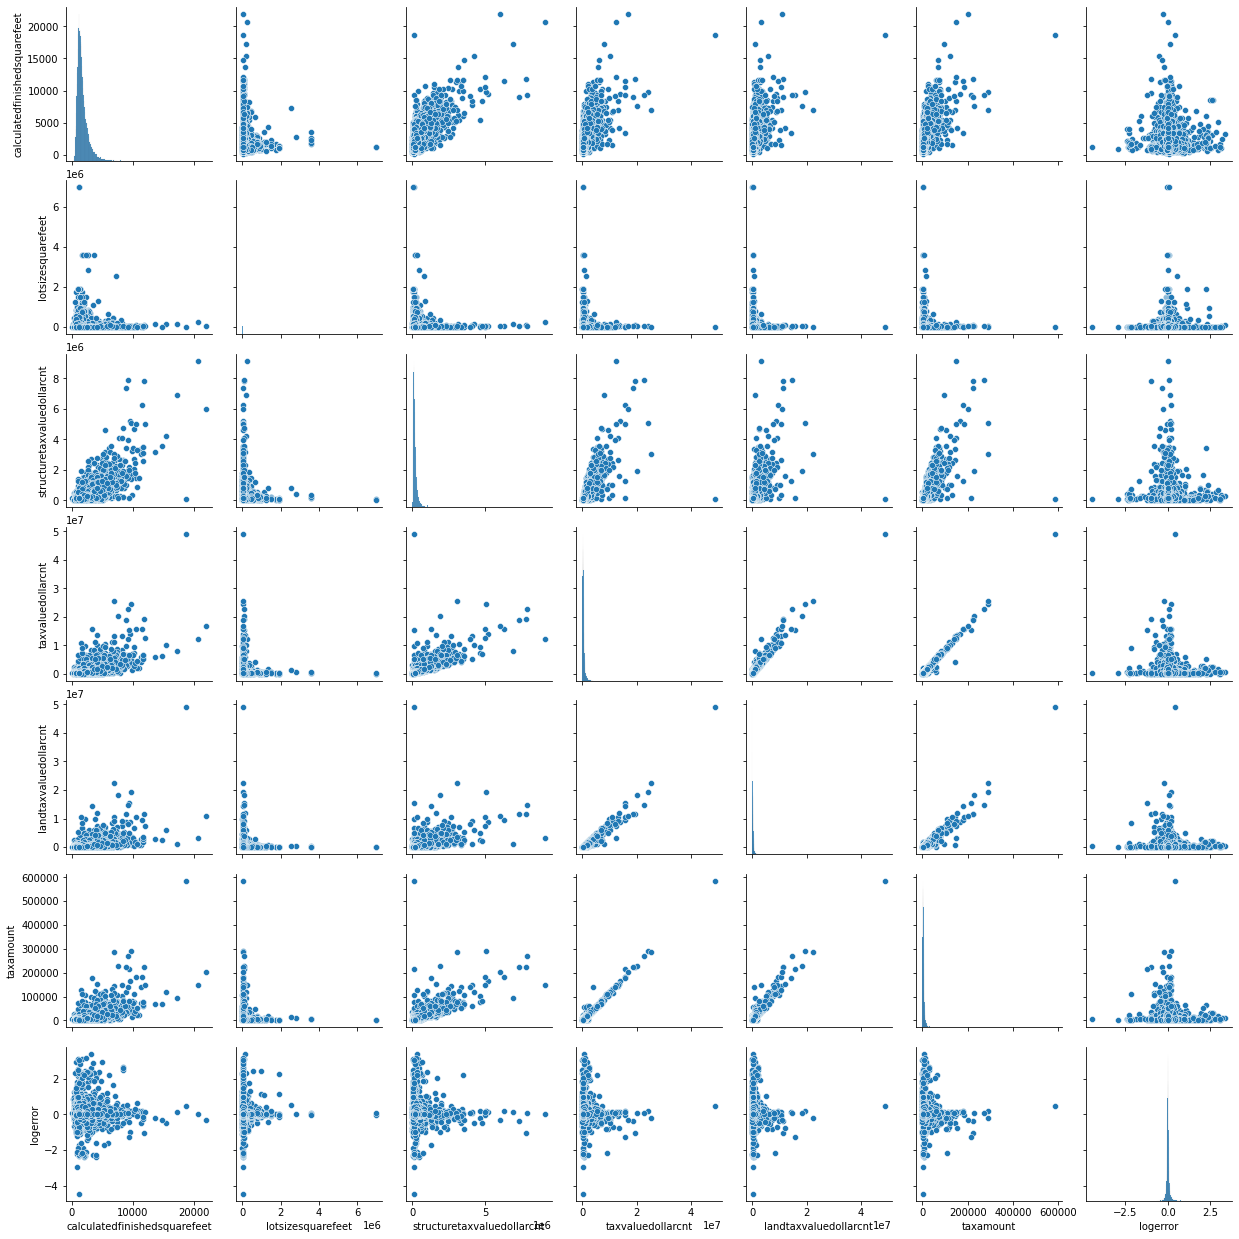

In [11]:
sns.pairplot(data=train[numeric_columns]);

2. Plot a correlation matrix heatmap.

In [12]:
# To make a fancy heatmap, we can use a template provided by seaborn

# Create a variable to store correlations between each datapoint
corr = train.corr()

# Create a mask in two steps

# 1. Using np.zeros_like(df) creates a matrix with the same dimensions as df, filled with 0.
mask = np.zeros_like(corr)

# 2. Using np.triu_indicies_from(mask) selects the middle diagonal to the top right of the matrix
# Those points are set to True.
mask[np.triu_indices_from(mask)] = True

# Use sns.axes_style() to remove the points where mask=True.

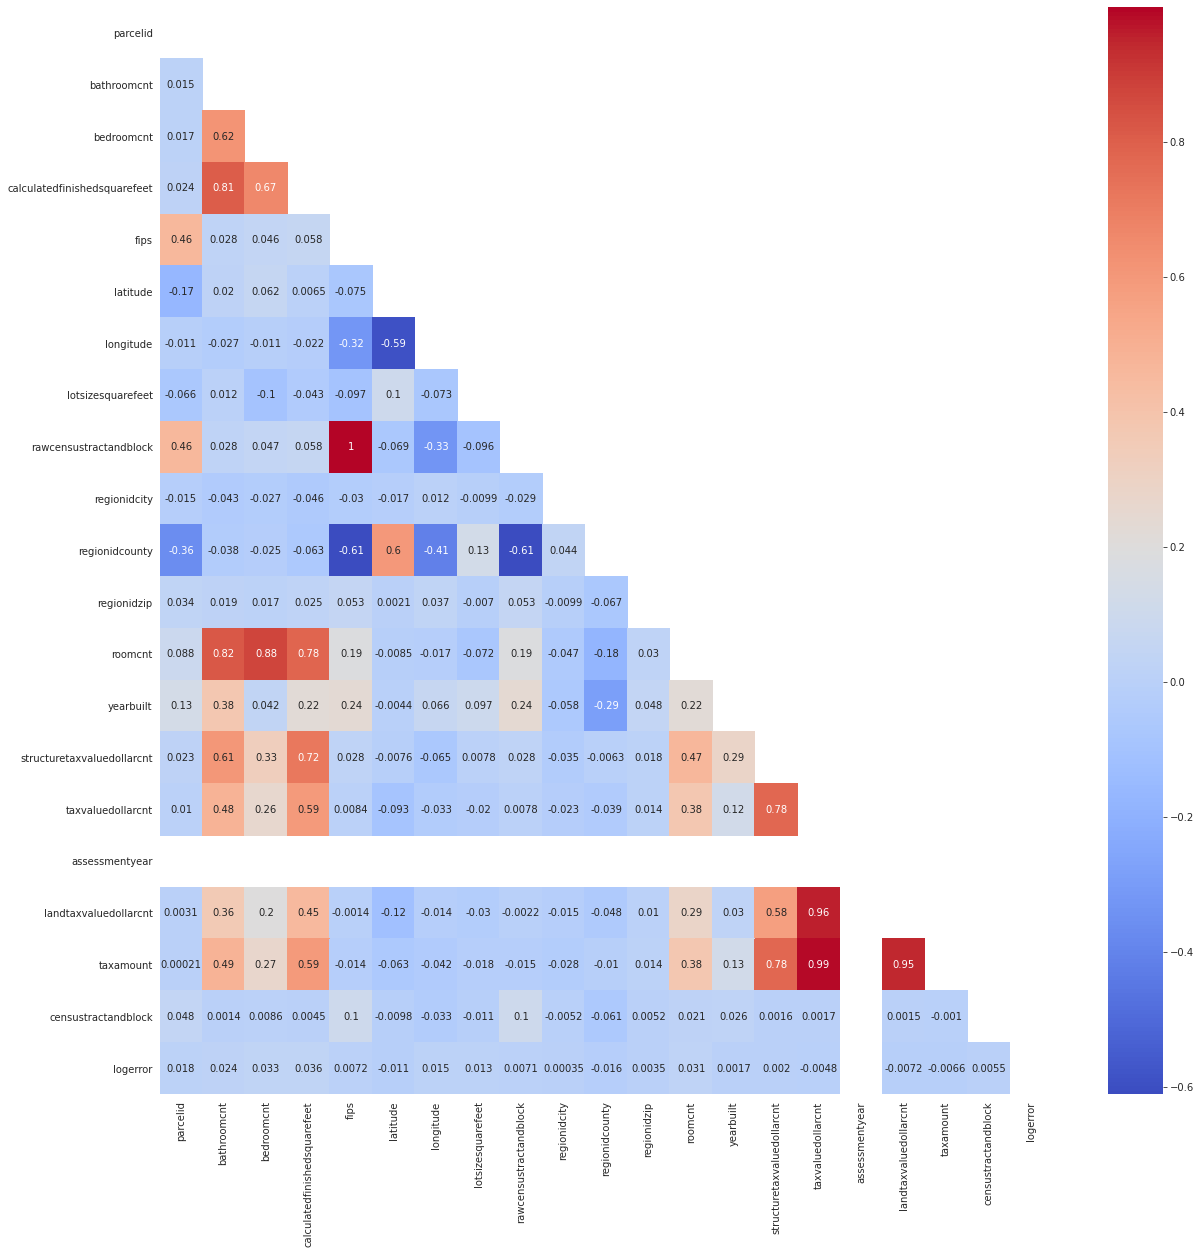

In [13]:
with sns.axes_style("white"):
    plt.figure(figsize=(20,20))
    sns.heatmap(corr,
                cmap='coolwarm',
                annot=True,
                mask=mask
               );

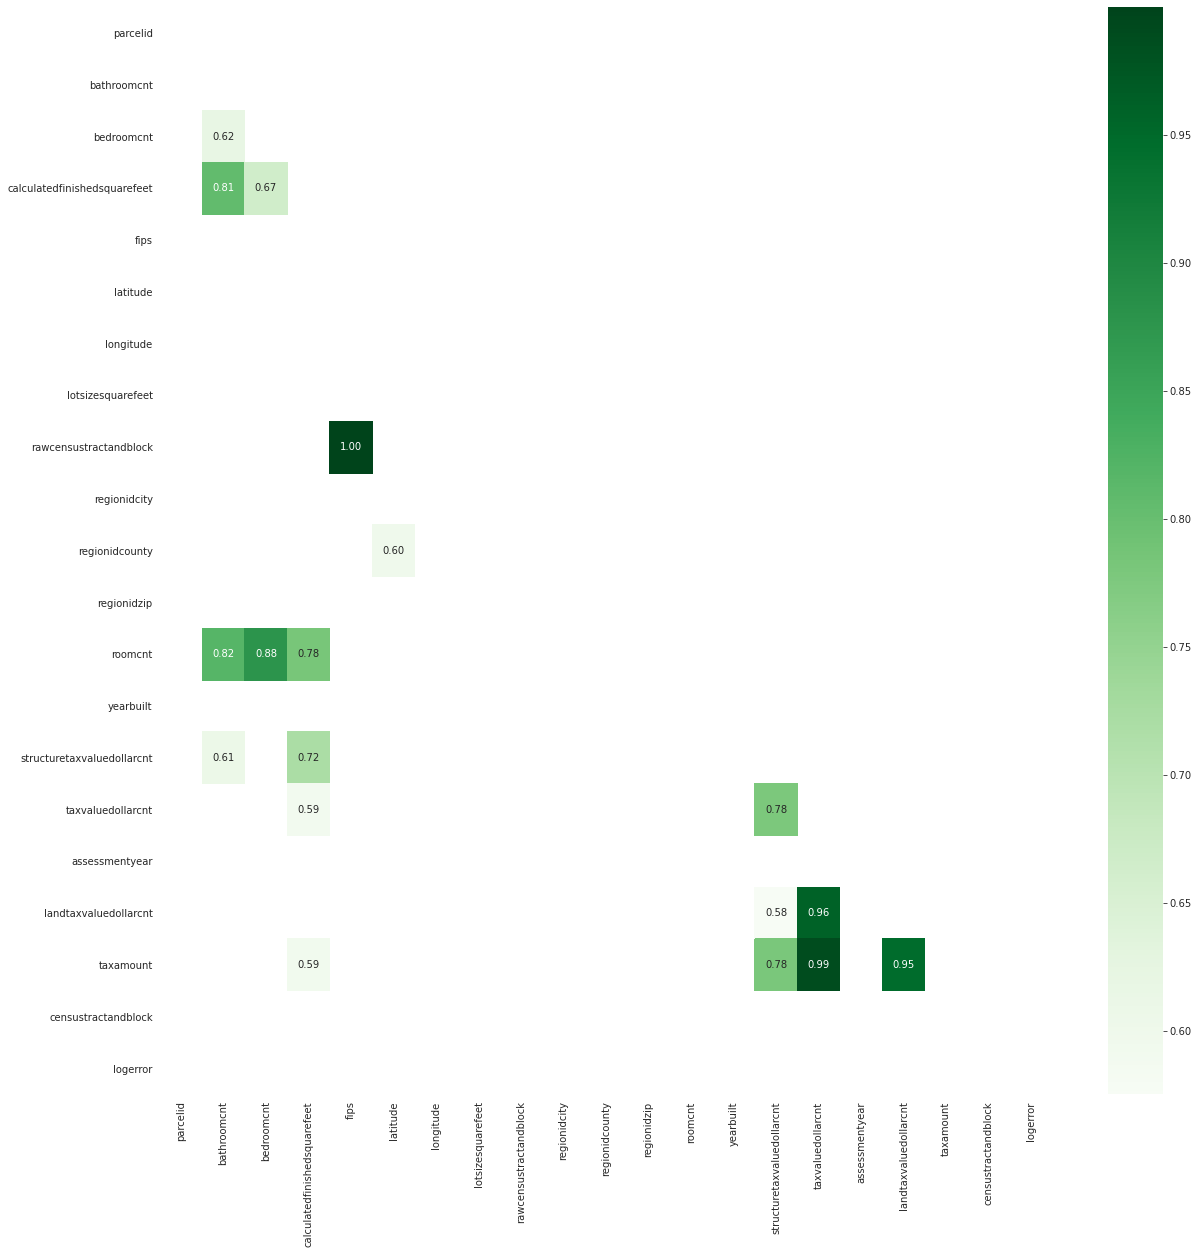

In [14]:
# 3 different correlation maps
with sns.axes_style("white"):
    plt.figure(figsize=(20,20))
    sns.heatmap(corr[corr>.5],
                cmap='Greens',
                annot=True,
                fmt=".2f",
                mask=mask
               );

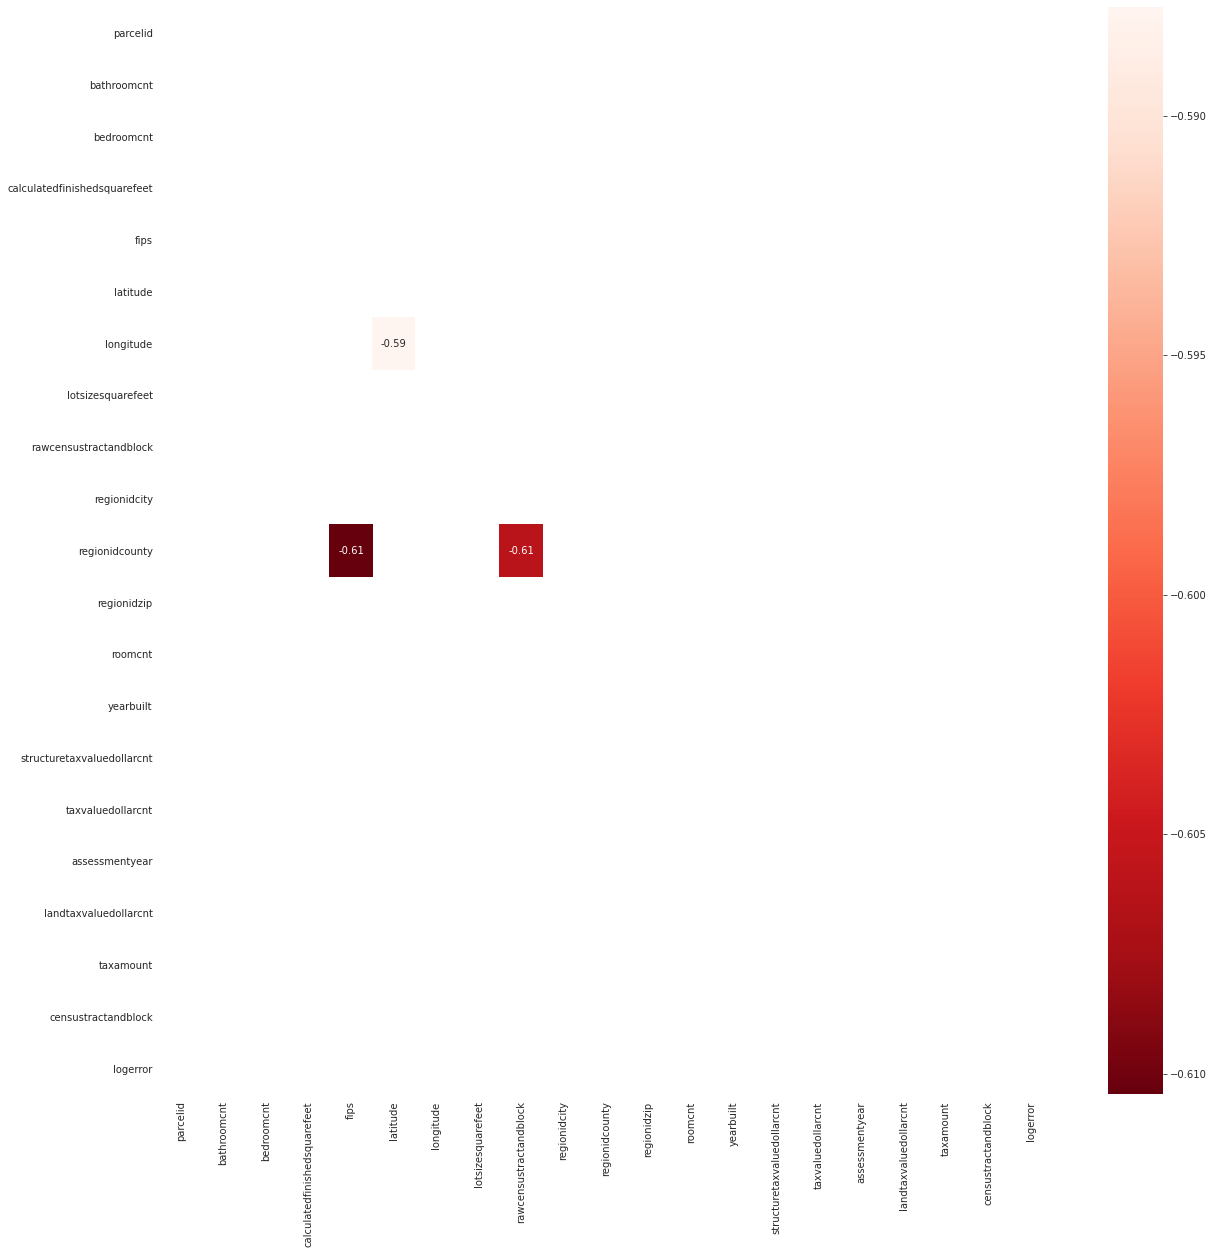

In [15]:
with sns.axes_style("white"):
    plt.figure(figsize=(20,20))
    sns.heatmap(corr[corr<-.5],
               cmap='Reds_r',
               annot=True,
               fmt=".2f",
               mask=mask);

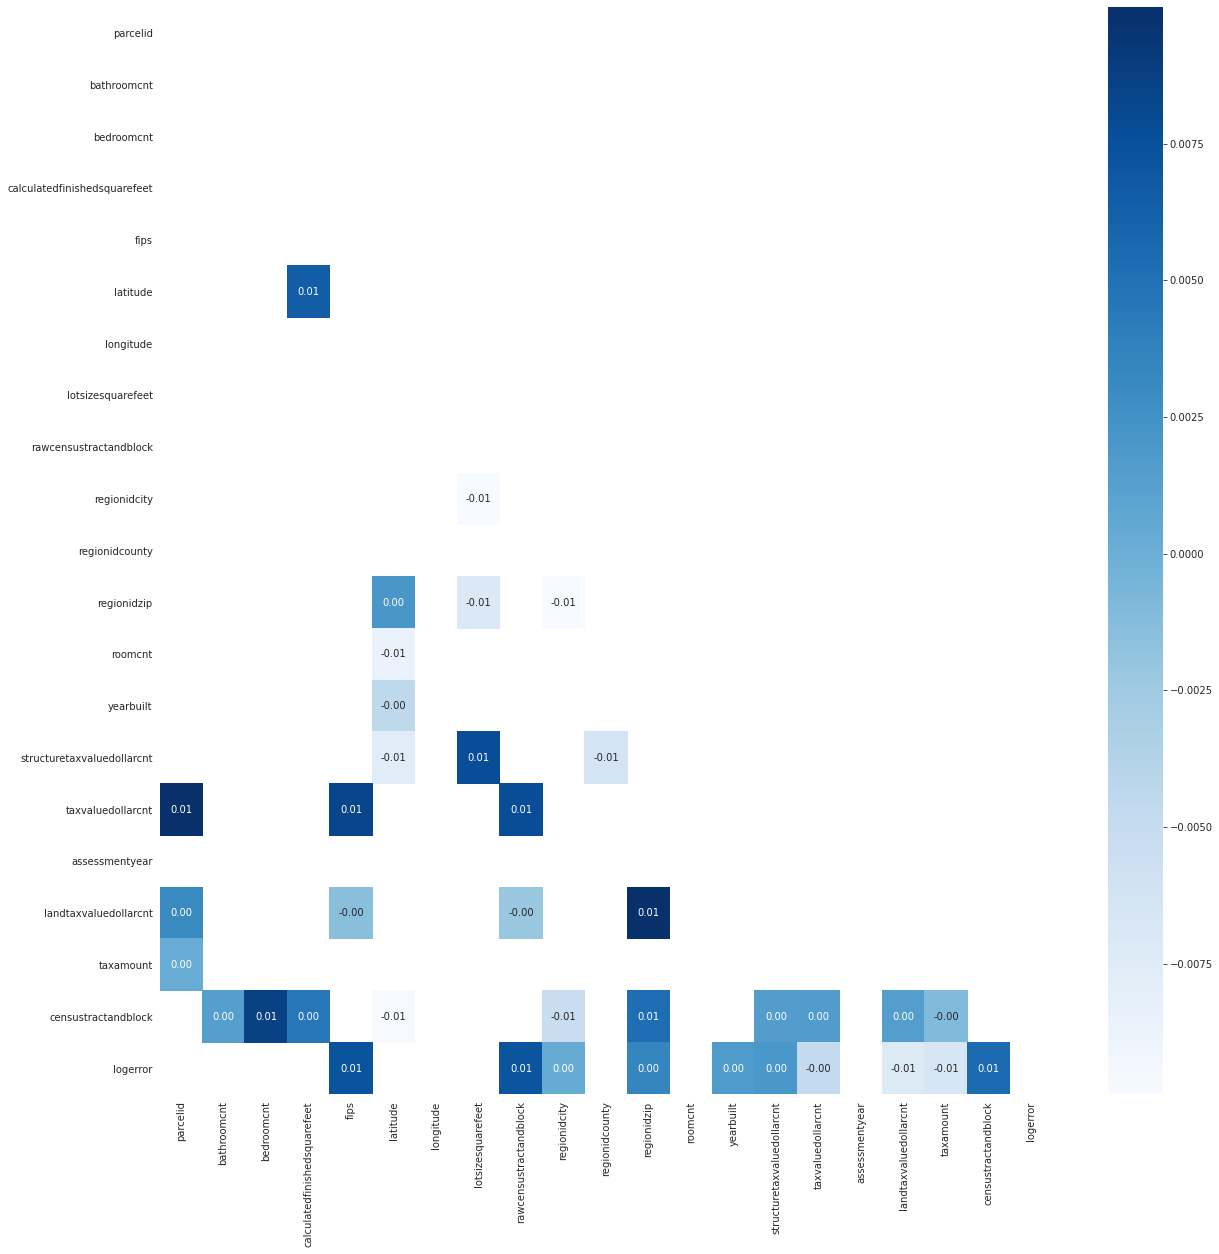

In [16]:
with sns.axes_style("white"):
    plt.figure(figsize=(20,20))
    sns.heatmap(corr[abs(corr)<.01],
                cmap='Blues',
                annot=True,
                fmt=".2f",
                mask=mask
               );

3. Plot latitude against longitude.

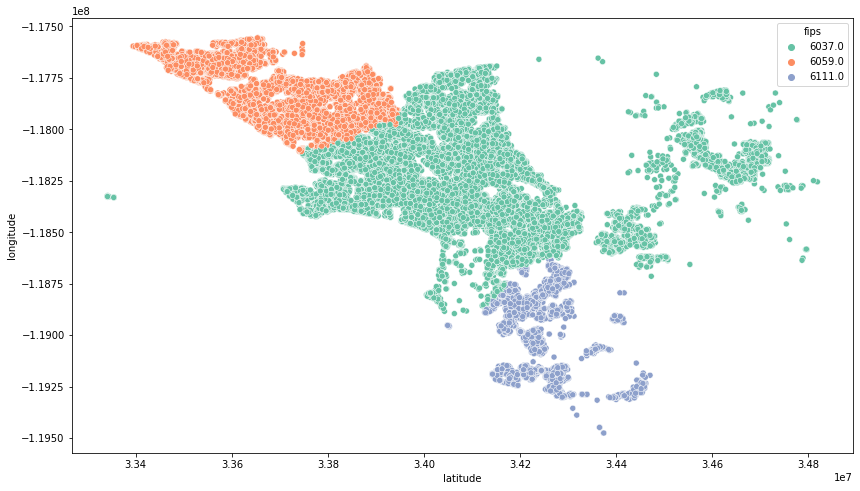

In [17]:
plt.figure(figsize=(14, 8))
sns.scatterplot(train.latitude, train.longitude, hue=train.fips, palette='Set2');

4. Create a useable plot with 4 dimensions, e.g. x, y, color, size.

In [25]:
train['binned_rooms'] = pd.cut(train.roomcnt,
                               bins=[0, 4, 8, 12, 16],
                               labels=[4, 8, 12, 16]
                              )

<Figure size 1008x720 with 0 Axes>

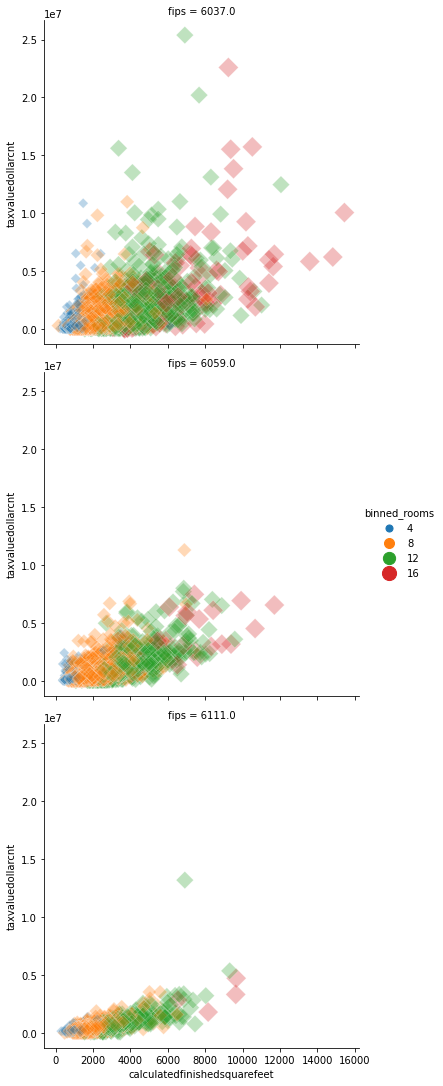

In [30]:
plt.figure(figsize=(14, 10));
sns.relplot(y=train.taxvaluedollarcnt,
            x=train.calculatedfinishedsquarefeet,
            col=train.fips,
            col_wrap=1,
            hue=train.binned_rooms,
            marker='D',
            alpha=.3,
            size=train.binned_rooms,
            sizes=(200, 50)
           );

<Figure size 1008x720 with 0 Axes>

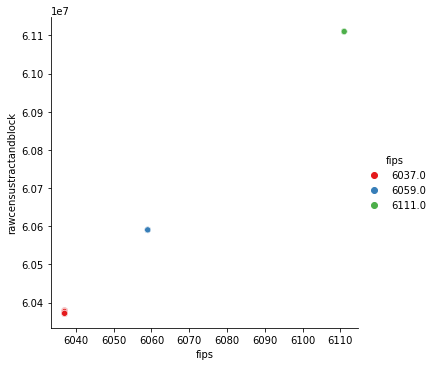

In [21]:
# Interesting, fips is 100% correlated with rawcensusblock
plt.figure(figsize=(14, 10));
sns.relplot(y=train.rawcensustractandblock,
            x=train.fips,
            palette='Set1',
            hue=train.fips
           );

In [22]:
# Now I see why. The first 4 digits correspond to the fips
# Each property is located in.
# I'll go back and drop rawcensustract and block
pd.crosstab(train.rawcensustractandblock, train.fips)

fips,6037.0,6059.0,6111.0
rawcensustractandblock,,,
6.037101e+07,1,0,0
6.037101e+07,1,0,0
6.037101e+07,1,0,0
6.037101e+07,2,0,0
6.037101e+07,1,0,0
...,...,...,...
6.111009e+07,0,0,2
6.111009e+07,0,0,1
6.111009e+07,0,0,1


5. Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [23]:
average_log_error = train.logerror.mean()
zips_log_error = train.groupby('regionidzip').logerror.mean()

In [47]:
zip_codes = train.regionidzip.value_counts().index.to_list()

In [69]:
len(zip_codes)

387

In [74]:
alpha = 0.05
zip_code = []
p_value = []
t_statistic = []

# Tried using groupby but ran into errors 
for i in zip_codes:
    zip_mean_error = train[train.regionidzip == i].logerror
    t, p = stats.ttest_1samp(zip_mean_error, average_log_error)
    if p < alpha:
        zip_code.append(i)
        t_statistic.append(t)
        p_value.append(p)

In [75]:
significant_zip_codes = pd.DataFrame({'zip_code': zip_code,
                                      't-statistic': t_statistic,
                                      'p-value': p_value
                                     })

6. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

In [77]:
orange_county = train[train.fips == 6037.0].logerror
los_angeles = train[train.fips == 6059.0].logerror
ventura = train[train.fips == 6111.0].logerror

In [85]:
t, p = stats.f_oneway(orange_county, los_angeles, ventura)
if p < alpha:
    print("The logerror is significantly different for properties in the 3 counties.")
    print(f"T-statistic: {t:.2f}")
    print(f"p-value: {p:.6f}")

The logerror is significantly different for properties in the 3 counties.
T-statistic: 6.43
p-value: 0.001614
